In [5]:

from pypylon import pylon
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------------ CAMERA SETUP ------------------------

# Connect to camera
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

# Set camera parameters
camera.PixelFormat.SetValue("Mono8")
camera.Gain.SetValue(0)

# Optional: turn off auto functions
try:
    camera.ExposureAuto.SetValue("Off")
except:
    pass

# ------------------------ CAPTURE IMAGES ------------------------

# Define 10 exposure times (in microseconds)


📷 Capturing 10 frames at different exposures...
✅ Captured exposure 100 µs
✅ Captured exposure 500 µs
✅ Captured exposure 700 µs
✅ Captured exposure 1000 µs
✅ Captured exposure 1500 µs
✅ Captured exposure 2000 µs
📈 Generating 3D intensity plot...


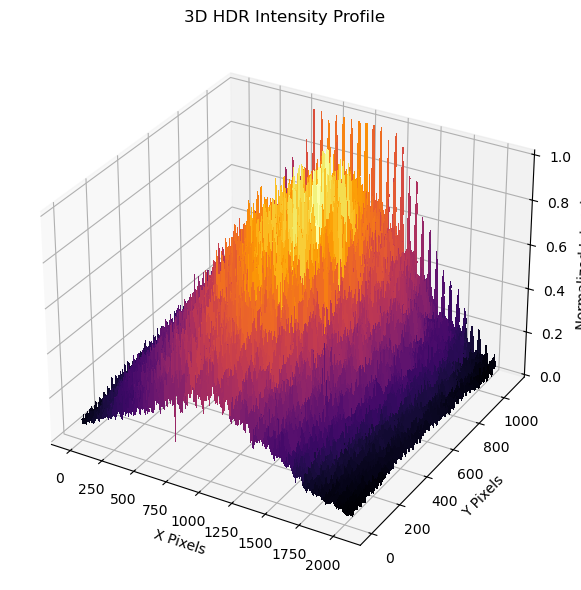

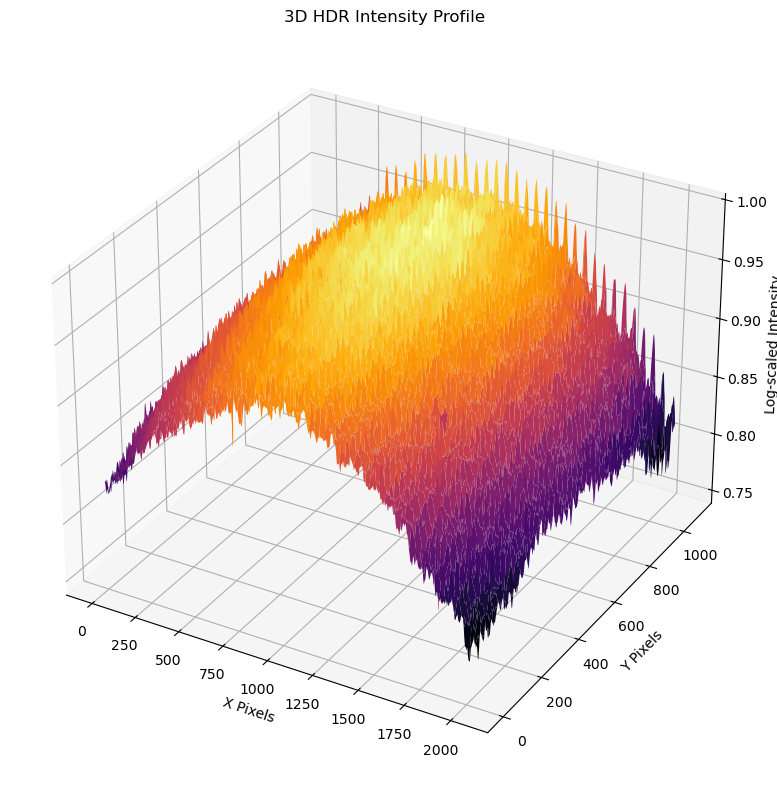

In [ ]:
exposure_times = np.array([100, 500, 700, 1000, 1500, 2000])  # µs
images = []
camera.Open()
# Image converter
converter = pylon.ImageFormatConverter()
converter.OutputPixelFormat = pylon.PixelType_Mono8
converter.OutputBitAlignment = pylon.OutputBitAlignment_MsbAligned

print("Capturing 10 frames at different exposures...")
for i, exp in enumerate(exposure_times):
    camera.ExposureTime.SetValue(float(exp))
    camera.StartGrabbingMax(1)

    while camera.IsGrabbing():
        grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
        if grab_result.GrabSucceeded():
            image = converter.Convert(grab_result)
            img = image.GetArray().astype(np.float32)
            images.append(img)
            print(f"Captured exposure {exp} µs")
        grab_result.Release()

camera.Close()

# ------------------------ HDR FUSION ------------------------

# Normalize images by exposure time (in seconds)
normalized_images = [img / (t * 1e-6) for img, t in zip(images, exposure_times)]

# HDR: pixel-wise max of normalized images
hdr = np.maximum.reduce(normalized_images)

# Save HDR data for later use
np.save("hdr_data.npy", hdr)

# Normalize for plotting
hdr_normalized = hdr / np.max(hdr)

# ------------------------ 3D PLOTTING ------------------------

print("Generating 3D intensity plot...")

# Create meshgrid
h, w = hdr.shape
x = np.arange(w)
y = np.arange(h)
X, Y = np.meshgrid(x, y)

# 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, hdr_normalized, cmap='inferno', linewidth=0, antialiased=False)
ax.set_title("3D HDR Intensity Profile")
ax.set_xlabel("X Pixels")
ax.set_ylabel("Y Pixels")
ax.set_zlabel("Normalized Intensity")
plt.tight_layout()
plt.show()

camera.Close()

# Use logarithmic scale for better contrast
hdr_log = np.log10(hdr + 1)  # +1 avoids log(0)
hdr_log_normalized = hdr_log / np.max(hdr_log)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
import scipy.ndimage

hdr_smooth = scipy.ndimage.gaussian_filter(hdr_log_normalized, sigma=2)

# Use smooth HDR image
ax.plot_surface(X, Y, hdr_smooth, cmap='inferno', linewidth=0, antialiased=True)

ax.set_title("3D HDR Intensity Profile")
ax.set_xlabel("X Pixels")
ax.set_ylabel("Y Pixels")
ax.set_zlabel("Log-scaled Intensity")
plt.tight_layout()
plt.show()

C:\Users\harsh\AppData\Local\Temp\ipykernel_16168\2866984417.py:21: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\harsh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


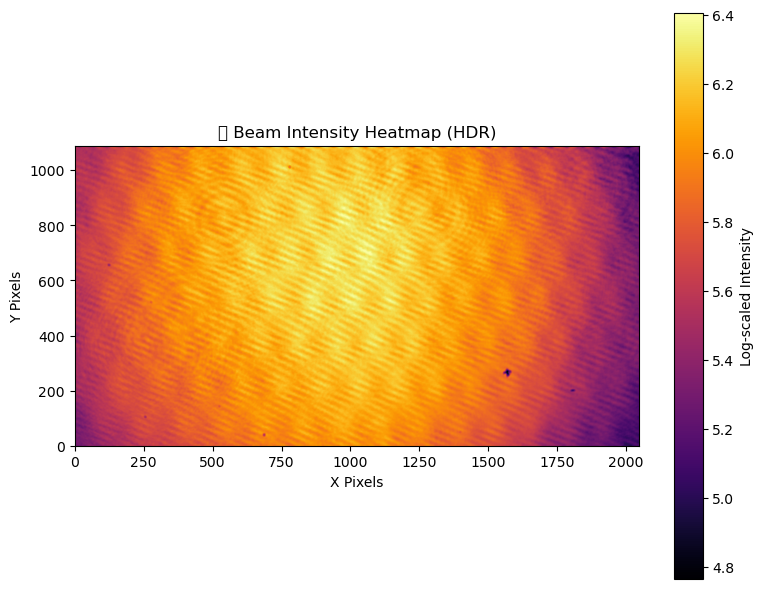

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Assuming you have your HDR intensity array:
# hdr = np.maximum.reduce(normalized_images)

# Optional: log scale to compress dynamic range
hdr_log = np.log10(hdr + 1e-8)

# Optional: apply Gaussian blur to smooth noise
hdr_smooth = gaussian_filter(hdr_log, sigma=2)

# --- Plot heatmap ---
plt.figure(figsize=(8, 6))
plt.imshow(hdr_smooth, cmap='inferno', origin='lower')
plt.colorbar(label="Log-scaled Intensity")
plt.title("🔥 Beam Intensity Heatmap (HDR)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.tight_layout()
plt.show()


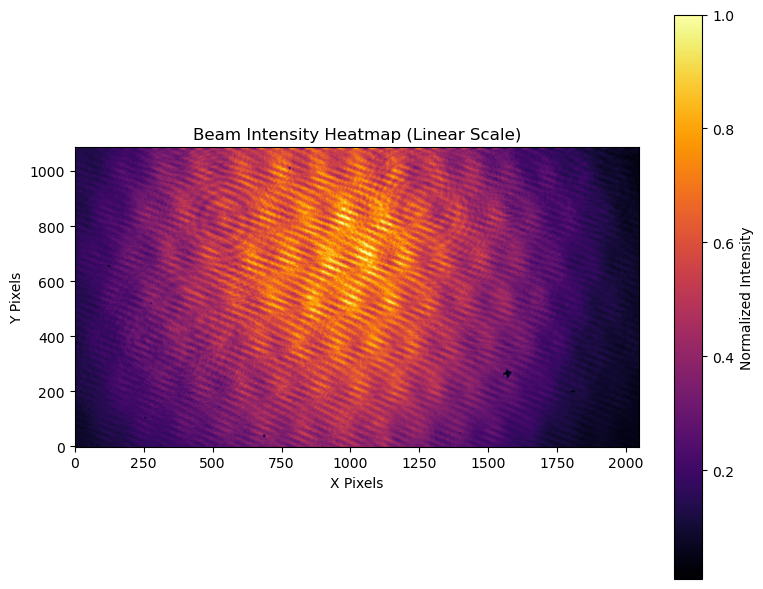

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize HDR to [0, 1] range
hdr_norm = hdr / np.max(hdr)

plt.figure(figsize=(8, 6))
plt.imshow(hdr_norm, cmap='inferno', origin='lower')
plt.colorbar(label="Normalized Intensity")
plt.title("Beam Intensity Heatmap (Linear Scale)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.tight_layout()
plt.show()


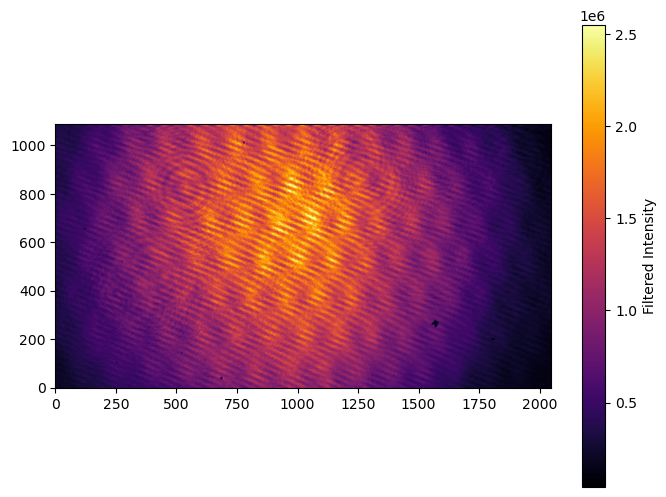

In [46]:
from scipy.ndimage import median_filter

# Apply 2D median filter (window size 3×3 or 5×5)
hdr_filtered = median_filter(hdr, size=3)
plt.figure(figsize=(8, 6))
plt.imshow(hdr_filtered, cmap='inferno', origin='lower')
plt.colorbar(label="Filtered Intensity")


✅ Rotated Symmetric Gaussian Fit:
 - Center (x₀, y₀):   (944.87, 665.90)
 - Symmetric σ:       555.52 pixels
 - FWHM:              1308.25 pixels
 - Rotation angle θ:  -239826527257.06°
 - Amplitude:         0.751
 - Offset:            -0.023


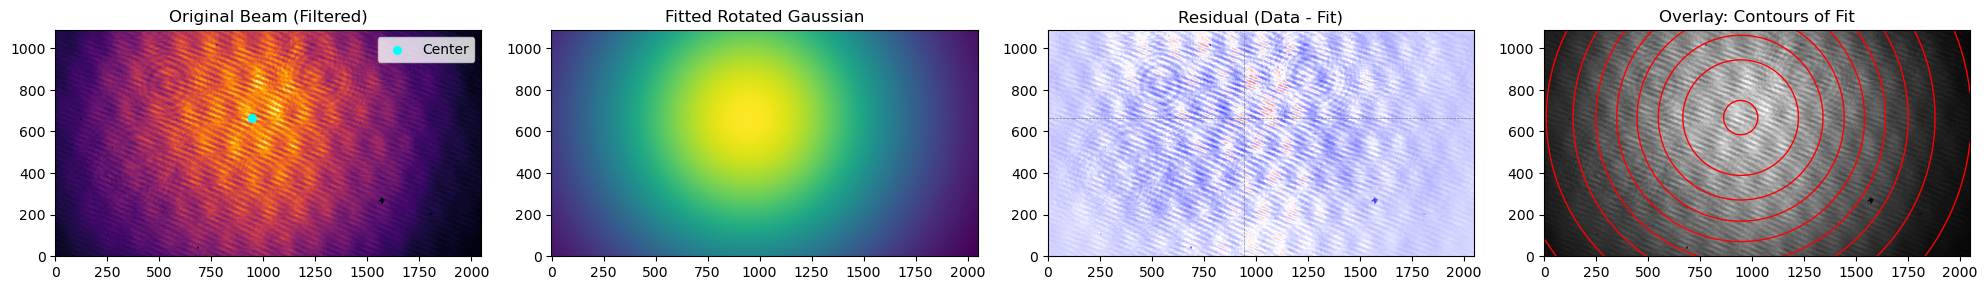

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

# --- Step 1: Prepare Data ---
hdr_norm = hdr_filtered / np.max(hdr_filtered)
h, w = hdr_norm.shape
x = np.arange(w)
y = np.arange(h)
x, y = np.meshgrid(x, y)
coords = (x, y)
data_flat = hdr_norm.ravel()

# --- Step 2: Define Rotated Symmetric Gaussian ---
def rotated_symmetric_gaussian(coords, amplitude, xo, yo, sigma, theta, offset):
    x, y = coords
    xo = float(xo)
    yo = float(yo)
    theta = float(theta)

    x_shift = x - xo
    y_shift = y - yo

    x_rot = x_shift * np.cos(theta) + y_shift * np.sin(theta)
    y_rot = -x_shift * np.sin(theta) + y_shift * np.cos(theta)

    r_squared = x_rot**2 + y_rot**2
    g = offset + amplitude * np.exp(-r_squared / (2 * sigma**2))
    return g.ravel()

# --- Step 3: Initial Parameters ---
initial_guess = (
    1,         # Amplitude
    w / 2,     # x0
    h / 2,     # y0
    w / 6,     # sigma
    0.0,       # theta in radians
    0          # offset
)

# --- Step 4: Fit Gaussian ---
popt, _ = curve_fit(rotated_symmetric_gaussian, coords, data_flat, p0=initial_guess, maxfev=10000)
amplitude, x0, y0, sigma, theta, offset = popt
fwhm = 2.355 * sigma
angle_deg = np.degrees(theta)

# --- Step 5: Generate Fitted Data ---
fitted = rotated_symmetric_gaussian(coords, *popt).reshape(h, w)
residual = hdr_norm - fitted

# --- Step 6: Print Fit Info ---
print("\n✅ Rotated Symmetric Gaussian Fit:")
print(f" - Center (x₀, y₀):   ({x0:.2f}, {y0:.2f})")
print(f" - Symmetric σ:       {sigma:.2f} pixels")
print(f" - FWHM:              {fwhm:.2f} pixels")
print(f" - Rotation angle θ:  {angle_deg:.2f}°")
print(f" - Amplitude:         {amplitude:.3f}")
print(f" - Offset:            {offset:.3f}")

# --- Step 7: Plot Everything ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original heatmap
axes[0].imshow(hdr_norm, cmap='inferno', origin='lower')
axes[0].set_title("Original Beam (Filtered)")
axes[0].scatter(x0, y0, c='cyan', s=30, label='Center')
axes[0].legend()

# Fitted Gaussian
axes[1].imshow(fitted, cmap='viridis', origin='lower')
axes[1].set_title("Fitted Rotated Gaussian")

# Residual
axes[2].imshow(residual, cmap='bwr', origin='lower')
axes[2].set_title("Residual (Data - Fit)")
axes[2].axhline(y0, color='gray', linestyle='--', linewidth=0.5)
axes[2].axvline(x0, color='gray', linestyle='--', linewidth=0.5)

# Overlay contours
axes[3].imshow(hdr_norm, cmap='gray', origin='lower')
contours = axes[3].contour(fitted, levels=8, colors='red', linewidths=1)
axes[3].set_title("Overlay: Contours of Fit")

plt.tight_layout()
plt.show()


In [2]:
import pypylon as pylon